### 需求：
2019.9.1-2019.11.30 报名1104（订单编号）课包的用户，多长时间后用户状态变更为vip，成为vip时上过几次课？
从大数据的角度看，目前我们的团队效率如何，同时以此数据给销售做一个参考。用户在多长时间内转化是比较合理的。

In [1]:
from odps import ODPS, options
from odps.df import agg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
options.sql.use_odps2_extension = True
odps = ODPS('LTAItDVDpC9aEMXJ', 'U6iEFCZCzoPUbjou1FW45SQruxIfFt', 'Qkids_V2_dev')

In [4]:
buy_1104_students = odps.get_table("t_student_buy_1104").to_df().to_pandas()

TransientProgressBar(value=0.0)

InstancesProgress()

HTMLNotifier()

In [5]:
len(buy_1104_students)

71406

在2019.9.1-2019.11.30购买1104的用户人数为: 71406人

In [6]:
students = buy_1104_students.loc[(buy_1104_students.min_large_product_id.isna()) | (buy_1104_students.min_large_paid_at > buy_1104_students.min_small_paid_at)]
all_num = len(students)
all_num

71049

去除了已经是购买大单的用户后: 71049

In [7]:
tmp1 = students.min_large_paid_at.isna().sum()
tmp2 = all_num - tmp1
tmp_rate = round(tmp2 / all_num, 2)
print(f"其中购买大单的用户: {tmp2}人， 未购买为: {tmp1}人。 转化率为: {tmp_rate}")

其中购买大单的用户: 12112人， 未购买为: 58937人。 转化率为: 0.17


In [8]:
big_students = students.loc[~students.min_large_product_id.isna()]
new_bit_students = big_students.set_index('student_id')

In [9]:
day_interval = new_bit_students.min_large_paid_at - new_bit_students.min_small_paid_at
c = day_interval.apply(lambda x: round(x.total_seconds()/3600/24))
vc = c.value_counts()
c.describe()

count    12112.000000
mean        16.633256
std         14.772284
min          0.000000
25%          6.000000
50%         12.000000
75%         22.000000
max         95.000000
dtype: float64

购买了大单的用户平均转化时间是16.63天

<BarContainer object of 94 artists>

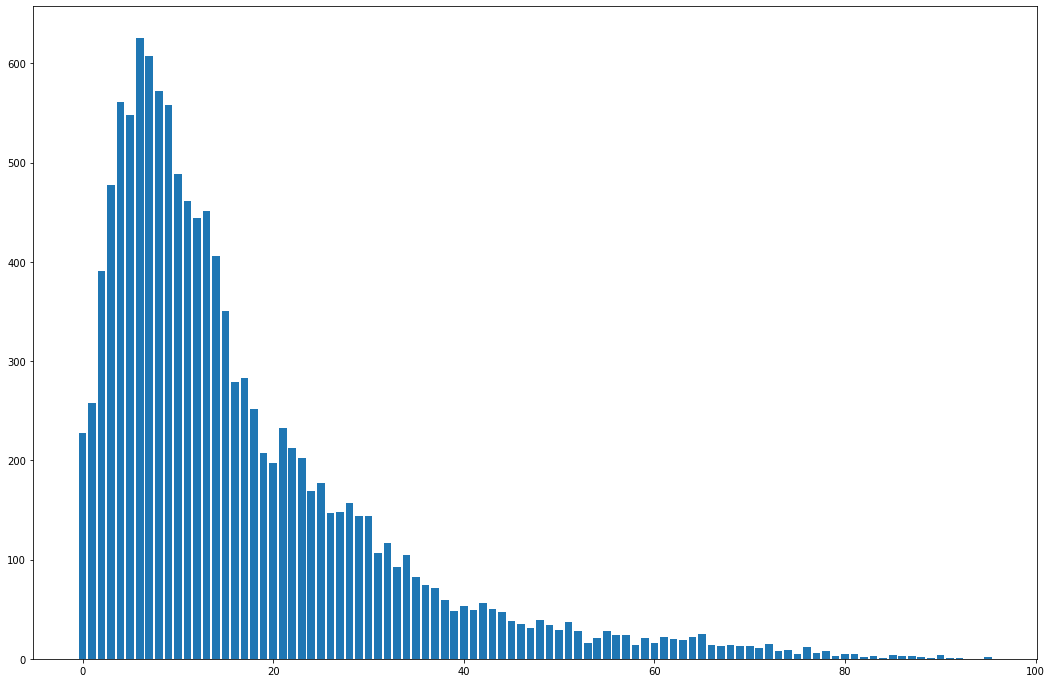

In [10]:
f = plt.figure(figsize=(18,12))
# plt.title("用户购买大单转化时间图---x轴是转化天数，y轴是x天妆化的人数")
plt.bar(vc.index, vc.values)

用户购买大单转化时间图---x轴是转化天数，y轴是x天妆化的人数

In [73]:
pd.cut(vc, [1,10,16,30,60])

6             NaN
7             NaN
8             NaN
4             NaN
9             NaN
         ...     
95    (0.0, 10.0]
89    (0.0, 10.0]
91    (0.0, 10.0]
84    (0.0, 10.0]
92    (0.0, 10.0]
Length: 94, dtype: category
Categories (4, interval[int64]): [(0, 10] < (10, 15] < (15, 30] < (30, 60]]

--- 

天数频率分桶 数
+ 1-10 
+ 11-15
+ 16-30
+ 31-60

In [15]:
pd.cut(c, [0,10,15,30,60]).value_counts() 

(0, 10]     5087
(15, 30]    2951
(10, 15]    2112
(30, 60]    1445
dtype: int64

天数频率分桶 比例

In [19]:
pd.cut(c, [0,10,15,30,60]).value_counts() / len(c)

(0, 10]     0.419997
(15, 30]    0.243643
(10, 15]    0.174373
(30, 60]    0.119303
dtype: float64

##### 当天购买人数 228人

In [20]:
(c ==0).sum()

228